# Impact on Housing and Community

This notebook shows an analysis of the impact of the war on Gaza for housing and communities. This is done using the following indicators as of March 
17th, 2024.

* Percentage of Residential Buildings Damaged.
* Percentage of Places of Worship Damaged.
* Percentage of People in Neighbourhoods with Damaged Buildings.
* Percentage of Places of Education Damaged.
* Places of Public Amenities Damaged.
* Percentage of Homes without (observed) Nighttime Lights.


In [1]:
import geopandas
from shapely.geometry import Point
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.tableau import TableauMedium_10
import math

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
sort_order = ["North Gaza", "Gaza", "Deir Al-Balah", "Khan Younis", "Rafah"]

In [3]:
def get_percentage_damaged(data, geog_level, variable, threshold, sort_order):
    left = (data[data[variable]>=threshold].groupby(geog_level).size()).to_frame('damaged')
    right = data.groupby(geog_level).size().to_frame('total')
    df = pd.merge(left, right, left_index = True, right_index = True, how = 'left')
    assert(not(df.isnull().values.any()))
    df["perc"] = 100 * df["damaged"] / df["total"]
    df = df.reindex(sort_order)
    return df

In [4]:
def hbarplot(data, suptitle, abs_value, perc_value, xlabel, ylabel, title, text):
    '''Create a horizontal bar plot'''
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.suptitle(suptitle, y=0.99, fontsize=20, x=0.54)
    absolute_damage_numbers = data[abs_value].values
    ax = data[perc_value].plot(ax=ax, kind="barh", legend=False)
    ax.invert_yaxis()
    # Add labels and customization
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
    
    ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
    ax.set_title(title, fontsize=14, loc="left")
    ax.text(0, -0.2, text, ha="left", va="center", transform=ax.transAxes, fontsize=10, color="black", weight="normal")

    if max(absolute_damage_numbers)>99999:
        flag_k = True
    else:
        flag_k = False
        
    for id, bar in enumerate(ax.patches):
        width = bar.get_width()  # Use width since the bars are horizontal
        if flag_k:
            ax.annotate(
                f"{absolute_damage_numbers[id] / 1_000:.0f}k",
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",
                color="white",
                ha="right",
                va="center",
                )

        else:
            ax.annotate(
                f"{int(np.round(absolute_damage_numbers[id],0))}",
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",
                color="white",
                ha="right",
                va="center",
                )

## Percentage of Residential Buildings Damaged
The damage assessment from [insert name of the class and link] was performed and produced a dataset in which for each OSM building, it has the probability of being damaged. That dataset is loaded, and each residential building with a probability equal or higher than 20% is considered damaged. 

In [ ]:
# Read shapefiles and filter GAZA area
PSE = geopandas.read_file(
    "../../../data/adm2_gaza/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [6]:
BUILDINGS_OSM = geopandas.read_file(
    "../../../data/damaged_buildings/damaged_buildings_OSM_10Apr2024_2_5sigma.shp"
).to_crs("EPSG:4326")

BUILDINGS_OSM = geopandas.sjoin(BUILDINGS_OSM, GAZA)
BUILDINGS_OSM["type"] = BUILDINGS_OSM["type"].fillna("")

In [7]:
# Filter OSM buildings for getting residential buildings
residential = BUILDINGS_OSM[BUILDINGS_OSM["type"].isin(["house", "apartments", "residential", "yes;house"])]
residential.loc[:, "type"] = "residential"

In [8]:
residential = get_percentage_damaged(residential, 'ADM2_EN', '_upd10mean', 0.2, sort_order)

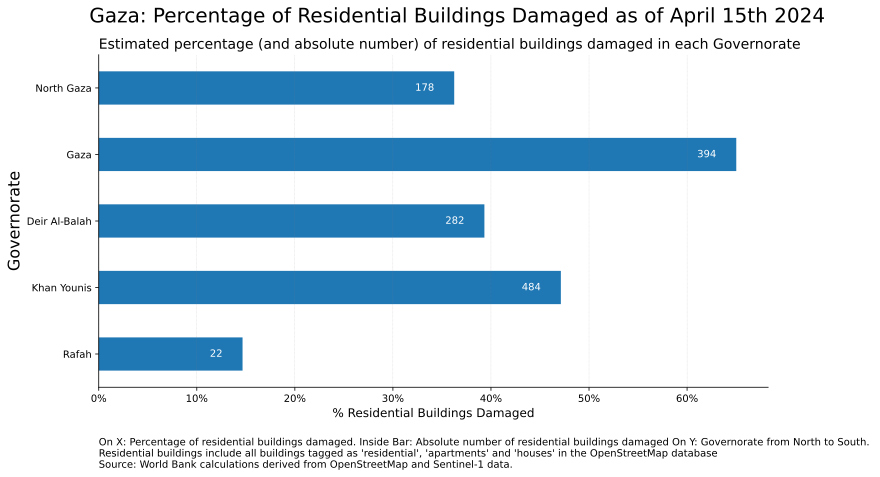

In [9]:
hbarplot(residential, 
         "Gaza: Percentage of Residential Buildings Damaged as of April 15th 2024", 
         'damaged', 
         'perc', 
         "% Residential Buildings Damaged", 
         "Governorate", 
         "Estimated percentage (and absolute number) of residential buildings damaged in each Governorate", 
         "On X: Percentage of residential buildings damaged. Inside Bar: Absolute number of residential buildings damaged On Y: Governorate from North to South. \nResidential buildings include all buildings tagged as 'residential', 'apartments' and 'houses' in the OpenStreetMap database\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.")

### Observations and Limitations

* More than 60% of residential buildings in Gaza, the second province from the north, can be considered damaged. However, in absolute numbers, Khan Younis has the most number of damaged residential buildings. 
* Residential buildings reported here include all the buildings tagged as 'residential', 'apartments' and 'houses' in OSM.
* In the OpenStreetMap database, Deir Al-Balah has 717 reported residential buildings, Khan Younis has 1027, Gaza has 606, North Gaza has 491, and Rafah has 150.
* Khan Younis was declared an evacuation zone by the Israeli Armed Forces, which could be a potential reason for the high number of damaged buildings. 

## Percentage of Places of Worship Damaged
The same methodology from residential buildings is applied to places of workship.

In [10]:
places_of_worship = BUILDINGS_OSM[
    BUILDINGS_OSM["type"].isin(["religious", "mosque", "church"])
]
places_of_worship.loc[:, "type"] = "places_of_worship"
places_of_worship = get_percentage_damaged(places_of_worship, 'ADM2_EN', '_upd10mean', 0.2, sort_order)

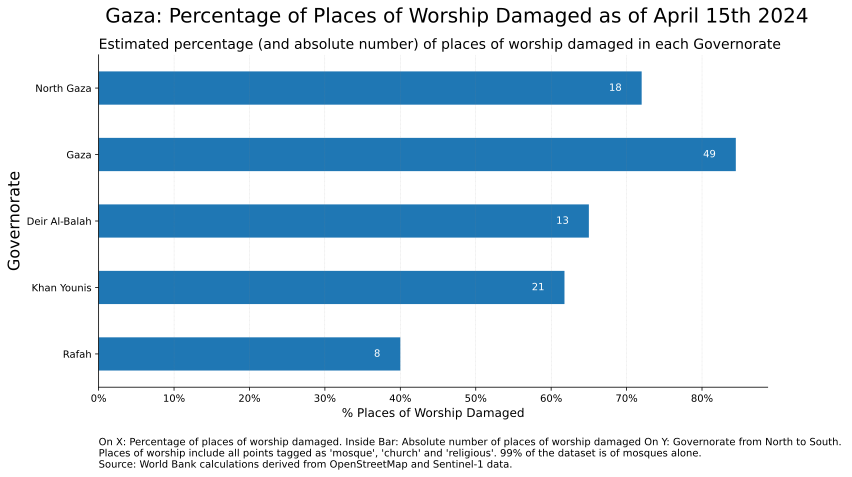

In [11]:
hbarplot(places_of_worship, 
         "Gaza: Percentage of Places of Worship Damaged as of April 15th 2024", 
         'damaged', 
         'perc', 
         "% Places of Worship Damaged", 
         "Governorate", 
         "Estimated percentage (and absolute number) of places of worship damaged in each Governorate", 
         "On X: Percentage of places of worship damaged. Inside Bar: Absolute number of places of worship damaged On Y: Governorate from North to South. \nPlaces of worship include all points tagged as 'mosque', 'church' and 'religious'. 99% of the dataset is of mosques alone.\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.")

### Observations and Limitations

* Gaza had the biggest hit on places of worship, both in terms of percentage and absolute numbers. 
* There are a total of 58 reported places of worship in Gaza, North Gaza has 25, Deir Al-Balah has 20, Khan Younis has 34, and Rafah has 20.
* There are no reported synagogues. 

## Percentage of People Living in Neighborhoods with Damaged Buildings
The methodology for creating this indicator is as follows:
1. Load the population data, which is at the point level.
2. Change the population geometry from points to polygons to be able to overlay the population with OSM buildings.
3. Calculate the mean damage by each population polygon.
4. Filter the population polygons that got a mean damage higher than 0.2.

In [12]:
def convert_to_gdf(df, X=None, Y=None):
    geometry = [Point(xy) for xy in zip(df[Y], df[X])]
    gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    return gdf

In [13]:
# Load the population data and filter population from Gaza strip
# Z stores the population
POPULATION = pd.read_csv("../../../data/pse_pd_2020_1km_UNadj_ASCII_XYZ.csv")
POPULATION = convert_to_gdf(POPULATION, "Y", "X")

POPULATION = POPULATION.sjoin(GAZA)
POPULATION = POPULATION[POPULATION["ADM1_EN"] == "Gaza Strip"]

In [14]:
POPULATION.explore()

In [15]:
# Function to create a 1 km^2 box around a point
def create_square_km_box(point):
    '''Create a 1 square Km box around each point'''
    lat, lon = point.y, point.x
    km_in_deg_lat = 1 / 111.32  # 1 km in degrees latitude
    km_in_deg_lon = 1 / (
        111.32 * math.cos(math.radians(lat))
    )  # 1 km in degrees longitude at this latitude

    # Define the bottom left and top right coordinates of the box
    bottom_left = (lon - km_in_deg_lon / 2, lat - km_in_deg_lat / 2)
    top_right = (lon + km_in_deg_lon / 2, lat + km_in_deg_lat / 2)

    # Create and return the box
    return box(*bottom_left, *top_right)

POPULATION["geometry"] = POPULATION["geometry"].apply(create_square_km_box)

In [16]:
population_impacted = POPULATION[
    [
        "X",
        "Y",
        "Z",
        "geometry",
        "ADM2_EN",
        "ADM2_PCODE",
        "ADM1_EN",
        "ADM1_PCODE",
        "ADM0_EN",
        "ADM0_PCODE",
    ]
].sjoin(
    BUILDINGS_OSM[
        BUILDINGS_OSM["type"].isin(["residential", "house", "apartments", "yes;house"])
    ][
        [
            "osm_id",
            "code",
            "fclass",
            "name",
            "type",
            "_max",
            "area",
            "_landusefc",
            "_upd10mean",
            "geometry",
        ]
    ]
)

In [17]:
population_adm2 = POPULATION.groupby(['ADM2_EN'])[['Z']].sum()
mean_impact = population_impacted.groupby(['X', 'Y'])[['_upd10mean']].mean()
population_impacted_adm2 = POPULATION.set_index(['X', 'Y']).loc[mean_impact[mean_impact['_upd10mean']>.2].index].groupby('ADM2_EN')[['Z']].sum()
population_adm2.rename(columns = {'Z': 'total_population'}, inplace = True)
population_adm2['damaged'] = population_impacted_adm2['Z']
population_adm2['perc'] = (population_adm2['damaged']/population_adm2['total_population'])*100

In [18]:
population_adm2 = population_adm2.reindex(sort_order)

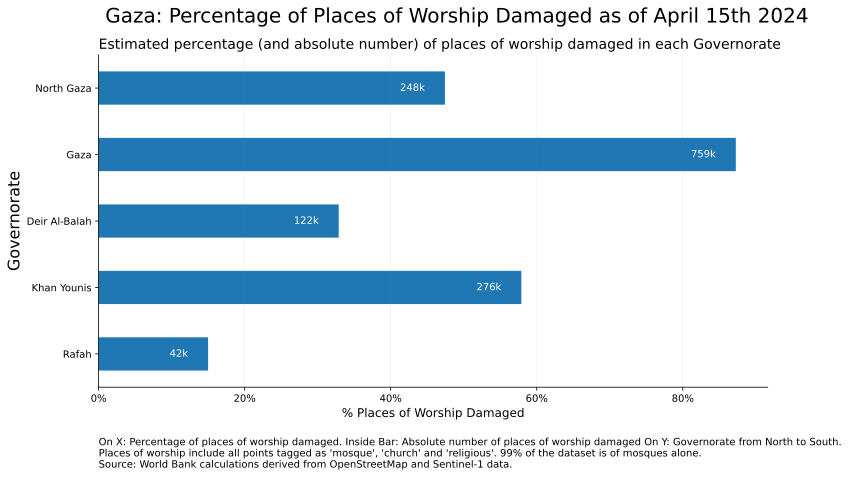

In [19]:
hbarplot(population_adm2, 
         "Gaza: Percentage of Places of Worship Damaged as of April 15th 2024", 
         'damaged', 
         'perc', 
         "% Places of Worship Damaged", 
         "Governorate", 
         "Estimated percentage (and absolute number) of places of worship damaged in each Governorate", 
         "On X: Percentage of places of worship damaged. Inside Bar: Absolute number of places of worship damaged On Y: Governorate from North to South. \nPlaces of worship include all points tagged as 'mosque', 'church' and 'religious'. 99% of the dataset is of mosques alone.\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.")

### Observations 

* Both North Gaza (523k) and Gaza (869k) have higher populations than Khan Younis (476k). This is a potential reason why the damage is higher in Khan Younis, but the number of people impacted is greater in the other two administrative regions.
* The population numbers are derived from WorldPop, which uses machine learning code to distribute population density top-down. This means that, sometimes, in areas where there are fewer people, the numbers reported in WorldPop could be higher, and vice versa. Therefore, the numbers reported here are the best approximation we can make with the data available. 

## Percentage of Schools and Public Amenities Damaged

In [20]:
POI = geopandas.read_file(
    "../../../data/damaged_buildings/damaged_pois_1_10Apr2024_2_5sigma.shp"
).to_crs("EPSG:4326")

# Add information about administrative levels
POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [21]:
def get_poi_classification(fclass):
    '''Classify the points of interest'''
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [22]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [23]:
education = get_percentage_damaged(POI[POI["type"] == "Education"], 
                                 'ADM2_EN', '_upd10max', 0.5, sort_order)
public_amenities = get_percentage_damaged(POI[POI["type"] == "Public Amenities"], 
                                 'ADM2_EN', '_upd10max', 0.5, sort_order)

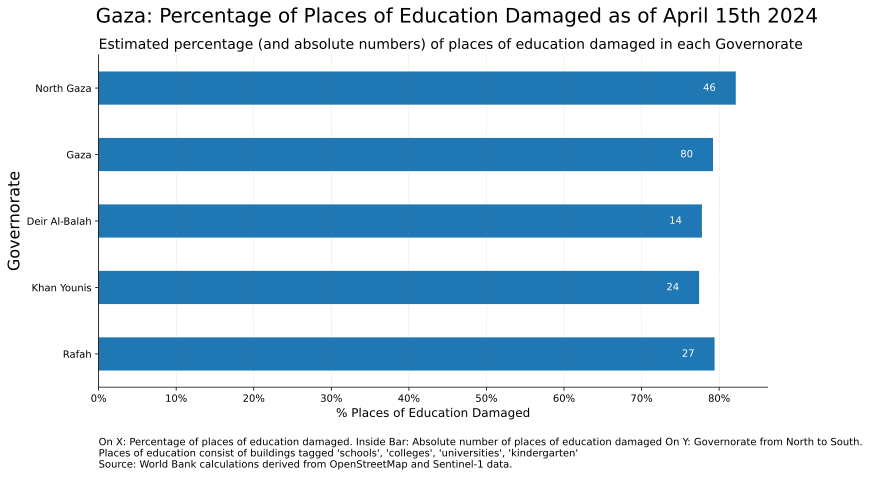

In [24]:
hbarplot(education,
        "Gaza: Percentage of Places of Education Damaged as of April 15th 2024",
        'damaged',
        'perc',
        "% Places of Education Damaged",
        "Governorate",
        "Estimated percentage (and absolute numbers) of places of education damaged in each Governorate",
        "On X: Percentage of places of education damaged. Inside Bar: Absolute number of places of education damaged On Y: Governorate from North to South. \nPlaces of education consist of buildings tagged 'schools', 'colleges', 'universities', 'kindergarten'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
    )

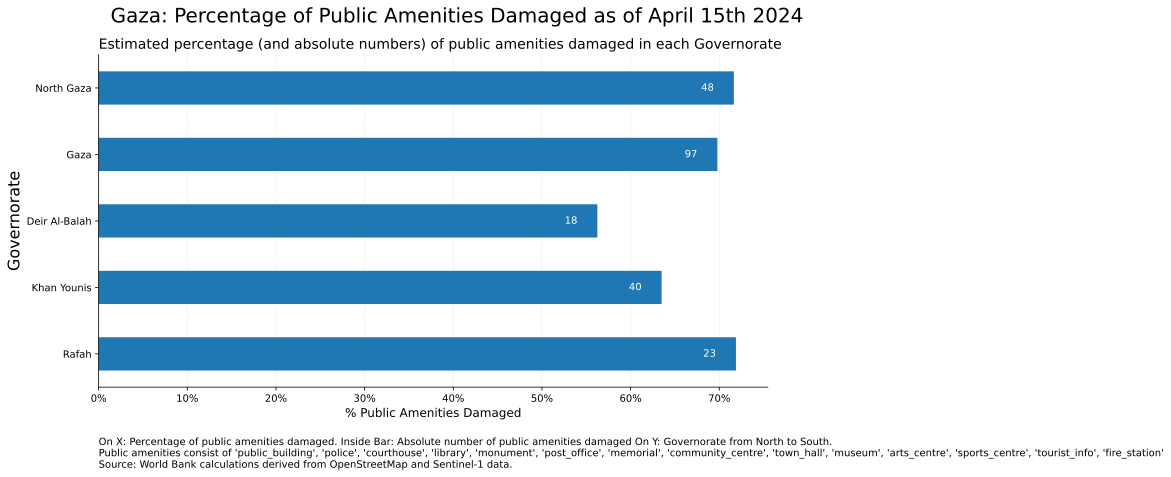

In [25]:
hbarplot(public_amenities,
        "Gaza: Percentage of Public Amenities Damaged as of April 15th 2024",
        'damaged',
        'perc',
        "% Public Amenities Damaged",
        "Governorate",
        "Estimated percentage (and absolute numbers) of public amenities damaged in each Governorate",
        "On X: Percentage of public amenities damaged. Inside Bar: Absolute number of public amenities damaged On Y: Governorate from North to South. \nPublic amenities consist of 'public_building', 'police', 'courthouse', 'library', 'monument', 'post_office', 'memorial', 'community_centre', 'town_hall', 'museum', 'arts_centre', 'sports_centre', 'tourist_info', 'fire_station'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
    )

## Percentage of Residential Buildings without Observed Nighttime Lights

Lower nighttime lights intensity, indicative of darker areas, may correspond to higher numbers of residential buildings without electricity. The chart below shows the percentage of residential buildings retrieved from [OpenStreetMap](https://www.hotosm.org) for which the nighttime lights intensity has decreased as of December 2023 by at least 95%, compared to September 2023 for each governorate in Gaza.

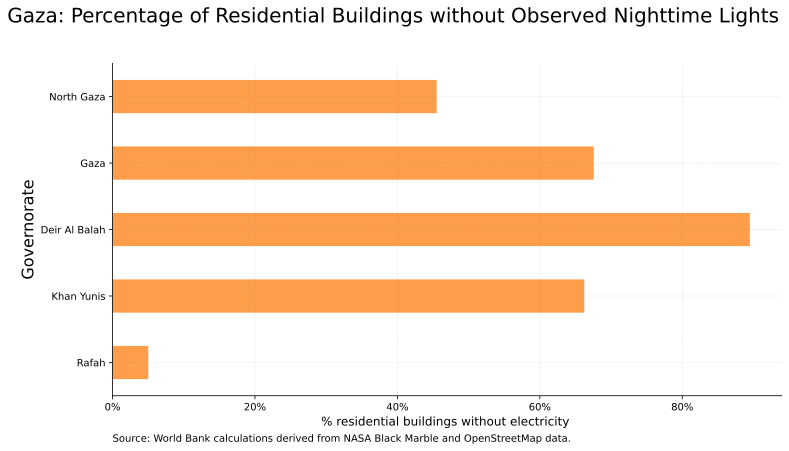

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle(
    "Gaza: Percentage of Residential Buildings without Observed Nighttime Lights",
    y=1.01,
    fontsize=20,
    x=0.45,
)

data = pd.read_csv(
    "../../../data/PSE_2-buildings_without_electricity.csv", index_col="name"
)[["% residential buildings without electricity"]].plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors[1], legend=False
)

# Add labels and customization
ax.set_xlabel("% residential buildings without electricity ", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)

# ax.set_title(
#     "Estimated percentage of buildings without electricity for each governorate",
#     fontsize=14,
# )
ax.text(
    0,
    -0.13,
    "Source: World Bank calculations derived from NASA Black Marble and OpenStreetMap data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

## Overall Impact on Housing and Community Place
This final step summarizes all the above indicators by administrative level 2 boundaries in a single table to provide a wider picture of the situation.

In [33]:
population_adm2.rename(
    columns={
        "perc": "% Population in Neighborhoods with Damaged Buildings",
        "damaged": "People in Neighborhoods with Damaged Buildings",
    },
    inplace=True,
)

residential.rename(
    columns={
        "damaged": "Number of Residential Buildings Damaged",
        "total": "residential_total",
        "perc": "% Residential Buildings Damaged",
    },
    inplace=True,
)

places_of_worship.rename(
    columns={
        "damaged": "Number of Places of Worship Damaged",
        "total": "places_of_worship_total",
        "perc": "% Places of Worship Damaged",
    },
    inplace=True,
)

education.rename(
    columns={
        "damaged": "Number of Places of Education Damaged",
        "total": "education_total",
        "perc": "% Places of Education Damaged",
    },
    inplace=True,
)

public_amenities.rename(
    columns={
        "damaged": "Number of Public Amenities Damaged",
        "total": "public_amenities_total",
        "perc": "% Public Amenities Damaged",
    },
    inplace=True,
)

In [34]:
summary_stats = pd.concat([
    residential,
    places_of_worship,
    population_adm2,
    education,
    public_amenities,
], axis = 1
)

In [35]:
sort_order = ["North Gaza", "Gaza", "Deir Al-Balah", "Khan Younis", "Rafah"]
summary_stats.reset_index(inplace=True)
summary_stats["ADM2_EN"] = pd.Categorical(
    summary_stats["ADM2_EN"], categories=sort_order, ordered=True
)
summary_stats.sort_values(by="ADM2_EN", inplace=True)
summary_stats.rename(columns={"ADM2_EN": "Governorate"}, inplace=True)
summary_stats.set_index("Governorate", inplace=True)

In [36]:
summary_stats[
    [
        "% Residential Buildings Damaged",
        "% Population in Neighborhoods with Damaged Buildings",
        "% Places of Worship Damaged",
        "% Places of Education Damaged",
        "% Public Amenities Damaged",
    ]
].style.background_gradient(cmap="viridis", axis=0).format("{:.0f}%")

## Observations

* The Governorate of Gaza took the greatest impact in almost every indicator being measured. The biggest, being the number of people potentially impacted (~720k). 
* The Governorate of North Gaza took impact on Points of Interest. However, this could also be because of the low number of reported buildings in the OpenStreetMap database.
* Khan Younis, a southern Governorate, has more than half its population living in neighborhoods with damaged buildings and without observed nighttime lights.

In [37]:
summary_stats

Number of Residential Buildings Damaged  residential_total  \
Governorate                                                                 
North Gaza                                         178                491   
Gaza                                               394                606   
Deir Al-Balah                                      282                717   
Khan Younis                                        484               1027   
Rafah                                               22                150   

               % Residential Buildings Damaged  \
Governorate                                      
North Gaza                           36.252546   
Gaza                                 65.016502   
Deir Al-Balah                        39.330544   
Khan Younis                          47.127556   
Rafah                                14.666667   

               Number of Places of Worship Damaged  places_of_worship_total  \
Governorate                                                                   
North Gaza                                      18                       25   
Gaza                                            49                       58   
Deir Al-Balah                                   13                       20   
Khan Younis                                     21                       34   
Rafah                                            8                       20   

               % Places of Worship Damaged  total_population  \
Governorate                                                    
North Gaza                       72.000000     523248.454512   
Gaza                             84.482759     869397.672607   
Deir Al-Balah                    65.000000     369606.987427   
Khan Younis                      61.764706     476073.810749   
Rafah                            40.000000     279377.634827   

               People in Neighborhoods with Damaged Buildings  \
Governorate                                                     
North Gaza                                      248144.936279   
Gaza                                            758657.895248   
Deir Al-Balah                                   121524.830139   
Khan Younis                                     275585.374329   
Rafah                                            41877.277649   

               % Population in Neighborhoods with Damaged Buildings  \
Governorate                                                           
North Gaza                                             47.423921      
Gaza                                                   87.262471      
Deir Al-Balah                                          32.879473      
Khan Younis                                            57.887111      
Rafah                                                  14.989488      

               Number of Places of Education Damaged  education_total  \
Governorate                                                             
North Gaza                                        46               56   
Gaza                                              80              101   
Deir Al-Balah                                     14               18   
Khan Younis                                       24               31   
Rafah                                             27               34   

               % Places of Education Damaged  \
Governorate                                    
North Gaza                         82.142857   
Gaza                               79.207921   
Deir Al-Balah                      77.777778   
Khan Younis                        77.419355   
Rafah                              79.411765   

               Number of Public Amenities Damaged  public_amenities_total  \
Governorate                                                                 
North Gaza                                     48                      67   
Gaza                                           97                     139   
Deir Al-Ba

In [38]:
summary_stats[
    [
        "Number of Residential Buildings Damaged",
        "People in Neighborhoods with Damaged Buildings",
        "Number of Places of Worship Damaged",
        "Number of Places of Education Damaged",
        "Number of Public Amenities Damaged",
    ]
].style.background_gradient(cmap="viridis", axis=0).format("{:.0f}")